In [1]:
%pylab
%matplotlib inline
import scipy.stats as st

import requests
import bs4
from collections import Counter
from io import StringIO
from datetime import date

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def suggest_num_bins(data):
    # suggests number of bins for histogram
    # using Freedman-Diaconis rule of thumb
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * IQR * (len(data)**(-1/3))
    return np.ceil((data.max() - data.min()) / bin_width)


def assess_normality_01(data, ddof=1, assume_discrete=False):
    # eerste methode: grafische controle
    if assume_discrete:
        bins = arange(min(data), max(data) + 2) - 0.5
        freq, bins, _ = plt.hist(data, bins=bins, normed=True)
    else:
        num_bins = suggest_num_bins(data)
        freq, bins, _ = plt.hist(data, bins=num_bins, normed=True)
    X = st.norm(data.mean(), data.std(ddof=ddof))
    x = (bins[1:] + bins[:-1]) / 2
    y = X.pdf(x)
    print("Method 1:")
    plt.plot(x, y, marker="o")
    plt.show()


def assess_normality_02(data, ddof=1):
    # tweede methode: grenzen std bepalen
    mu, stddev = data.mean(), data.std(ddof=ddof)
    print("Method 2:")
    for i in range(1, 4):
        within_std = sum(np.abs(data - mu) < i * stddev)
        print(
            "Percentage of data within {} std: {:.2f}%".format(
                i, 100 * (within_std / data.size)
            )
        )


def assess_normality_03(data, ddof=1):
    # derde methode: normal probability plot
    print("Method 3:")
    X = st.norm(data.mean(), data.std(ddof=1))
    x = sort(data)
    probs = linspace(1, len(x), num=len(x)) / len(x)
    y = X.ppf(probs)
    plt.plot(x[:-1], y[:-1], "o ")
    plt.plot([x.min(), x.max()], [x.min(), x.max()], "-")
    plt.axis('equal')
    plt.show()

Method 1:


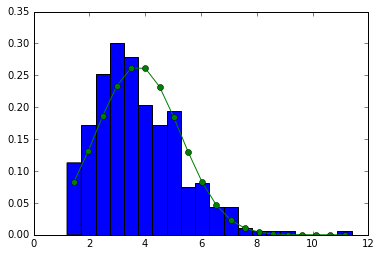

Method 2:
Percentage of data within 1 std: 71.51%
Percentage of data within 2 std: 95.89%
Percentage of data within 3 std: 98.90%
Method 3:


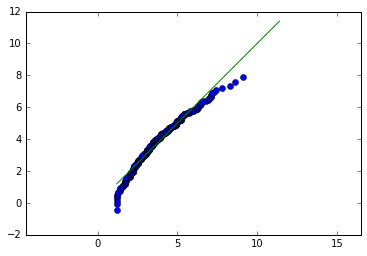

In [4]:
def load_knmi_data(start=date(2015, 1, 1), end=date(2015, 12, 31), station=350):
    url = "http://projects.knmi.nl/klimatologie/daggegevens/getdata_dag.cgi"
    data = {
        "byear": start.year,
        "bmonth": start.month,
        "bday": start.day,
        "eyear": end.year,
        "emonth": end.month,
        "eday": end.day,
        "stations": station,
        "variable": "FG",
    }
    r = requests.post(url, data=data)
    if r.status_code == requests.codes.ok:
        f = StringIO(r.text)  # use string as file
        return loadtxt(f, delimiter=",", usecols=(4,)) / 10
    raise Exception("Error occurred loading data from knmi.nl!")

data = load_knmi_data()
assess_normality_01(data, ddof=0)
assess_normality_02(data, ddof=0)
assess_normality_03(data, ddof=0)

Method 1:


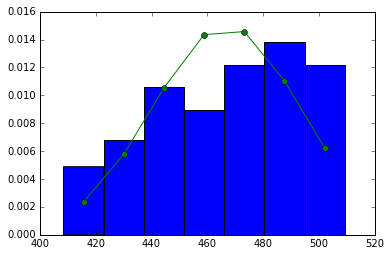

Method 2:
Percentage of data within 1 std: 59.77%
Percentage of data within 2 std: 97.66%
Percentage of data within 3 std: 100.00%
Method 3:


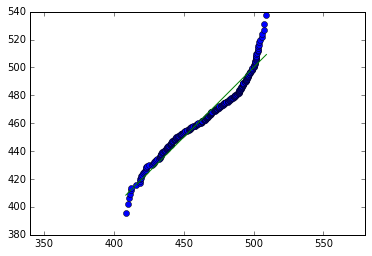

In [5]:
def load_aex_data(start=date(2015, 1, 1), end=date(2015, 12, 31), symbol="^AEX"):
    url = "http://real-chart.finance.yahoo.com/table.csv"
    data = {
        "s": symbol,
        "a": start.month - 1,
        "b": start.day,
        "c": start.year,
        "d": end.month - 1,
        "e": end.day,
        "f": end.year,
        "g": "d",
        "ignore": ".csv",
    }
    r = requests.get(url, params=data)
    if r.status_code == requests.codes.ok:
        f = StringIO(r.text)
        data = loadtxt(f, delimiter=",", skiprows=1, usecols=(4,))
        return data
    raise Exception("Error occurred downloading data from yahoo.com!")

data = load_aex_data()
assess_normality_01(data, ddof=0)
assess_normality_02(data, ddof=0)
assess_normality_03(data, ddof=0)

Method 1:


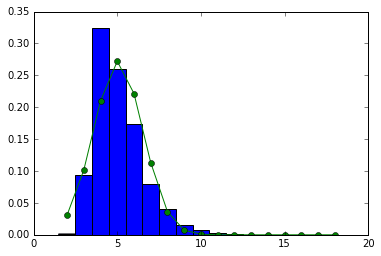

Method 2:
Percentage of data within 1 std: 75.84%
Percentage of data within 2 std: 93.27%
Percentage of data within 3 std: 98.93%
Method 3:


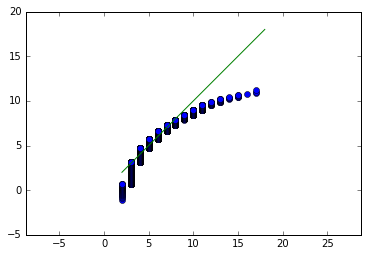

In [7]:
def filter_name(name):
    return "".join([letter for letter in name if letter.isalpha()])


def load_names():
    url = "https://www.svb.nl/system/js/kindernamen_jongens.json"
    r = requests.get(url)
    if r.status_code == requests.codes.ok:
        names = r.json()
        name_lengths = Counter()
        for table_item in names:
            name, freq, *_ = table_item
            name_length = len(filter_name(name))
            name_lengths[name_length] += freq
        return fromiter(name_lengths.elements(), dtype=int_)
    raise Exception("Error occurred downloading data from svb.nl!")

data = load_names()
assess_normality_01(data, ddof=0, assume_discrete=True)
assess_normality_02(data, ddof=0)
assess_normality_03(data, ddof=0)